In [1]:
#pip install openseespy
import openseespy.opensees as ops # OpenSeesPy main module
import opsvis as opsv # OpenSeesPy visualization module
import matplotlib.pyplot as plt # Matplotlib for plotting
import numpy as np # NumPy for numerical operations
import pandas as pd # Pandas for data manipulation
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [460]:
#Unidades base mks
m = 1
kg = 1
s = 1

#Otras unidades
cm = 0.01*m
kgf = 9.80665*kg*m/s**2
tonf = 1000*kgf

#Constantes Físicas
g = 9.80665*m/s**2

## Iniciando con el modelado

In [461]:
ops.wipe()
ops.model('basic', '-ndm', 3, '-ndf', 6) # 3D model with 6 DOF per node

## Genera nodos

In [462]:
def generar_nodos_reticula(
    numero_ejes_x: int,
    numero_ejes_y: int,
    numero_entrepiso: int,
    separacion_x: float,
    separacion_y: float,
    altura_entrepiso: float,
    incluir_nivel_base: bool = True,
    origen: tuple[float, float, float] = (0.0, 0.0, 0.0),
) -> pd.DataFrame:
    
    if numero_ejes_x < 2 or numero_ejes_y < 2:
        raise ValueError("numero_ejes_x y numero_ejes_y deben ser >= 2 (mínimo 2 ejes).")
    if numero_entrepiso < 1:
        raise ValueError("numero_entrepiso debe ser >= 1.")
    if separacion_x <= 0:
        raise ValueError("separacion_x debe ser > 0.")
    if separacion_y <= 0:
        raise ValueError("separacion_y debe ser > 0.")
    if altura_entrepiso <= 0:
        raise ValueError("altura_entrepiso debe ser > 0.")

    x0, y0, z0 = origen

    coordenadas_x = [x0 + i * separacion_x for i in range(numero_ejes_x)]
    coordenadas_y = [y0 + j * separacion_y for j in range(numero_ejes_y)]

    indices_nivel = range(0, numero_entrepiso + 1) if incluir_nivel_base else range(1, numero_entrepiso + 1)
    niveles_z = [z0 + k * altura_entrepiso for k in indices_nivel]

    nodos = [(x, y, z) for z in niveles_z for y in coordenadas_y for x in coordenadas_x]

    return pd.DataFrame(nodos, columns=["x", "y", "z"])


def exportar_nodos_a_excel(tabla_nodos: pd.DataFrame, ruta_excel: str = "nodos.xlsx") -> None:
    # Exporta con encabezados x y z en primera fila (sin índice)
    tabla_nodos.to_excel(ruta_excel, index=False)


numero_ejes_x = 3
numero_ejes_y = 2
numero_entrepiso = 3
incluir_nivel_base = True

separacion_x = 6.0
separacion_y = 5.0
altura_entrepiso = 3.2

ruta_excel = "nodos.xlsx"

tabla_nodos = generar_nodos_reticula(
    numero_ejes_x=numero_ejes_x,
    numero_ejes_y=numero_ejes_y,
    numero_entrepiso=numero_entrepiso,
    separacion_x=separacion_x,
    separacion_y=separacion_y,
    altura_entrepiso=altura_entrepiso,
    incluir_nivel_base=incluir_nivel_base,
    origen=(0.0, 0.0, 0.0)
)

exportar_nodos_a_excel(tabla_nodos, ruta_excel)

Total_nodos = len(tabla_nodos)
print("Archivo generado:", ruta_excel)
print("Total de nodos:", Total_nodos)

Archivo generado: nodos.xlsx
Total de nodos: 24


In [463]:
data1 = pd.read_excel("nodos.xlsx",sheet_name="Sheet1")
nodos = data1.to_numpy(dtype=np.float64)

In [464]:
for idx, nodoi in enumerate(nodos):
    ops.node(idx+1, *nodoi)

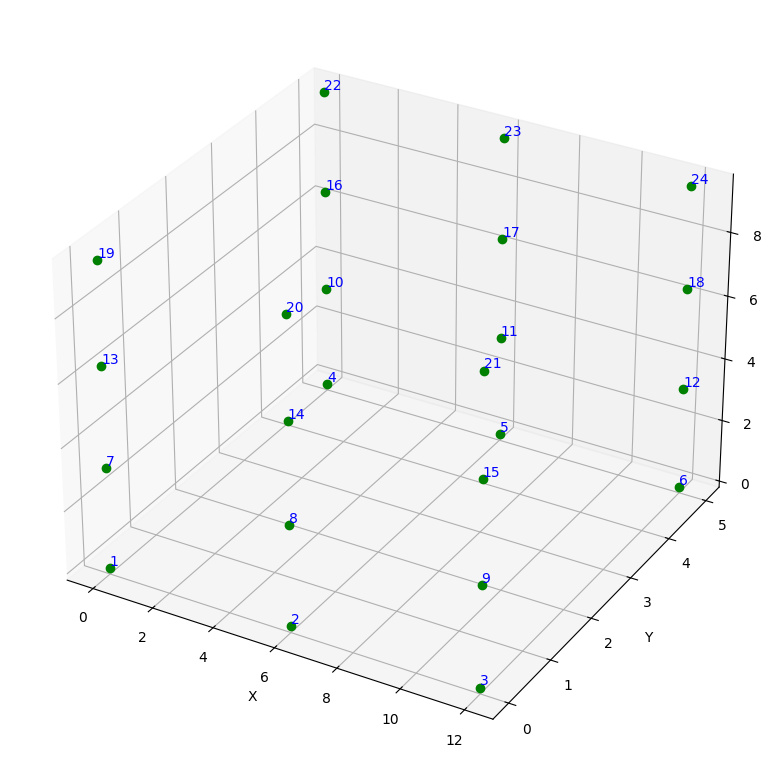

In [465]:
opsv.plot_model(fig_wi_he=(30,25))
plt.show()

### Condiciones de apoyo

In [466]:
ops.fixZ(0,*[1,1,1,1,1,1])

### Definición de materiales

In [467]:
fc = 280*kg/cm**2            # Resistencia a la compresion
E = 150*fc**0.5*kgf/cm**2    # Mpodulo de elasticidad
G = 0.5*E/(1+0.2)            # Modulo de corte

### Definición de sección

In [468]:
# Viga
b, h = 30*cm, 60*cm
Av = b*h
Izv = b*h**3/12
Iyv = b**3*h/12
aa, bb = max(b,h),min(b,h)
β = 1/3-0.21*bb/aa*(1-(bb/aa)**4/12)
Jxxv = β*bb**3*aa

# Columna
a = 45*cm
Ac = a**2
Izc = a**4/12
Iyc = a**4/12
β = 1/3-0.21*1*(1-(1)**4/12)
Jxxc = β*a**4

# Densidad del concreto
ρ = 2400*kg/m**3


In [469]:
CTransform = 1   # Etiqueta de la transformacion para columnas
BTransform = 2   # Etiqueta de la transformacion para vigas

ops.geomTransf('PDelta', CTransform, *[1,0,0])
ops.geomTransf('Linear', BTransform, *[0,0,1])

### Dibujar nuestros elementos viga columna

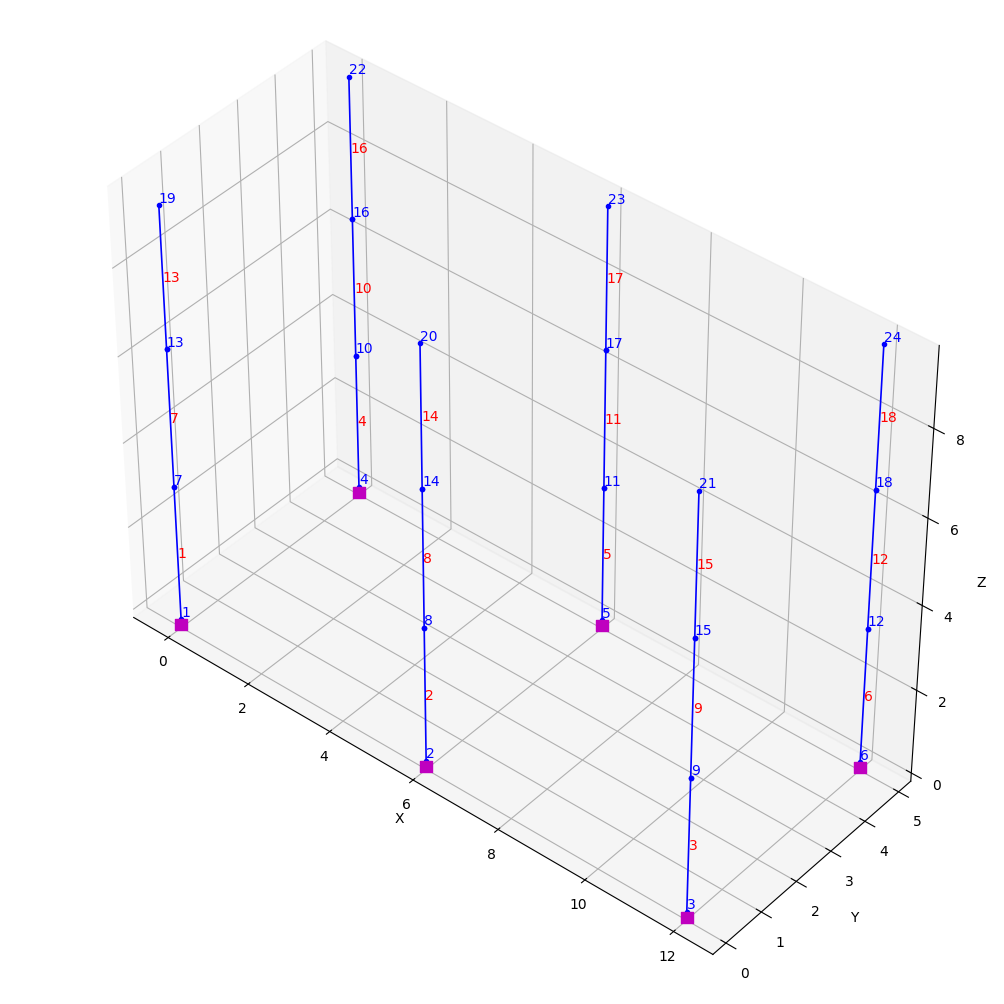

In [470]:
def id_nodo(ix, iy, iz, numero_ejes_x, numero_ejes_y):
    return 1 + ix + numero_ejes_x*iy + (numero_ejes_x*numero_ejes_y)*iz

numero_niveles = (numero_entrepiso + 1) if incluir_nivel_base else numero_entrepiso

tags_columnas = []
etiqueta_elemento = 1

for iz in range(numero_niveles - 1):
    for iy in range(numero_ejes_y):
        for ix in range(numero_ejes_x):
            nodo_i = id_nodo(ix, iy, iz, numero_ejes_x, numero_ejes_y)
            nodo_j = id_nodo(ix, iy, iz + 1, numero_ejes_x, numero_ejes_y)

            ops.element(
                'elasticBeamColumn',
                etiqueta_elemento,
                nodo_i, nodo_j,
                Ac, E, G, Jxxc, Iyc, Izc,
                CTransform,
                '-mass', ρ*Ac*10**-8
            )
            tags_columnas.append(etiqueta_elemento)
            etiqueta_elemento += 1

opsv.plot_model(fig_wi_he=(30.,25.),az_el=(-50,40),fig_lbrt = (0, 0, 1, 1),axis_off=0,local_axes=False)
plt.show()

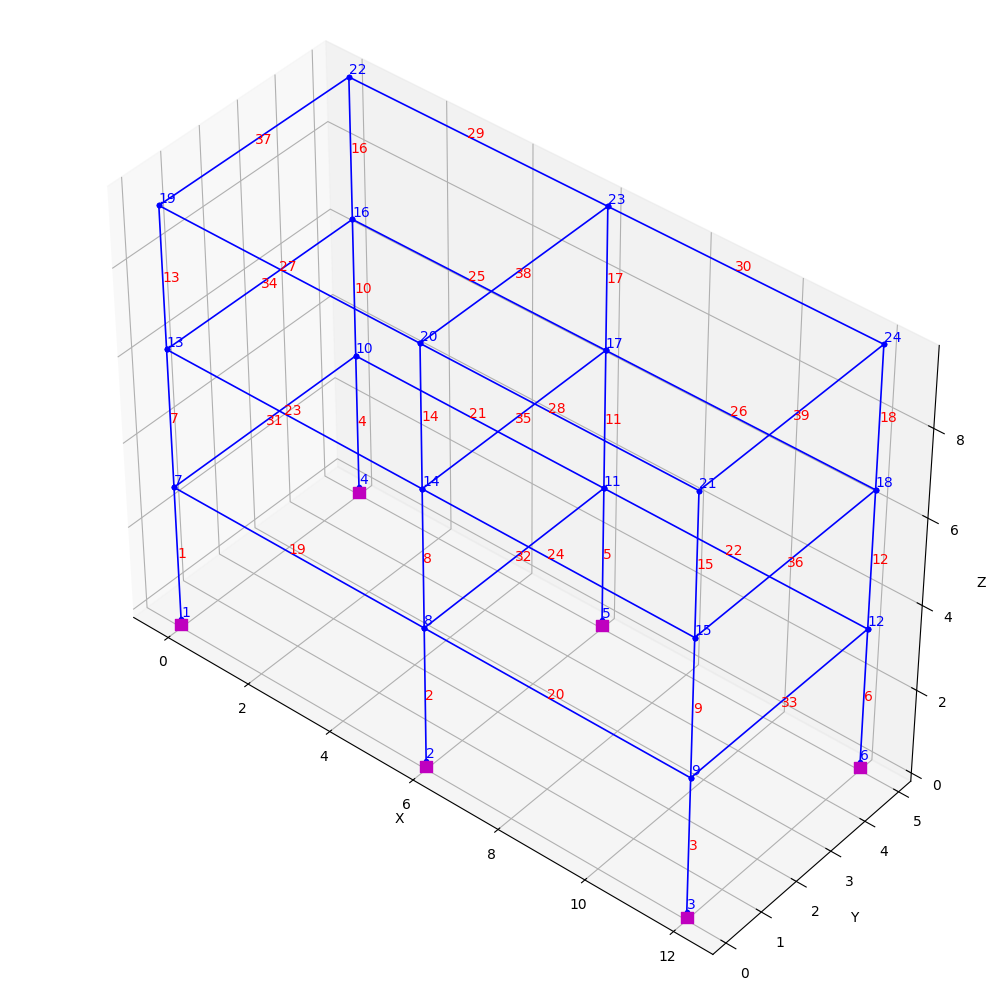

In [471]:
def id_nodo(ix, iy, iz, numero_ejes_x, numero_ejes_y):
    return 1 + ix + numero_ejes_x*iy + (numero_ejes_x*numero_ejes_y)*iz

numero_niveles = (numero_entrepiso + 1) if incluir_nivel_base else numero_entrepiso

tags_vigas = []

# Vigas en dirección X (desde iz=1 en adelante)
for iz in range(1, numero_niveles):
    for iy in range(numero_ejes_y):
        for ix in range(numero_ejes_x - 1):
            nodo_i = id_nodo(ix, iy, iz, numero_ejes_x, numero_ejes_y)
            nodo_j = id_nodo(ix + 1, iy, iz, numero_ejes_x, numero_ejes_y)

            ops.element(
                'elasticBeamColumn',
                etiqueta_elemento,
                nodo_i, nodo_j,
                Av, E, G, Jxxv, Iyv, Izv,
                BTransform,
                '-mass', ρ*Av*10**-8
            )
            tags_vigas.append(etiqueta_elemento)
            etiqueta_elemento += 1

# Vigas en dirección Y (desde iz=1 en adelante)
for iz in range(1, numero_niveles):
    for iy in range(numero_ejes_y - 1):
        for ix in range(numero_ejes_x):
            nodo_i = id_nodo(ix, iy, iz, numero_ejes_x, numero_ejes_y)
            nodo_j = id_nodo(ix, iy + 1, iz, numero_ejes_x, numero_ejes_y)

            ops.element(
                'elasticBeamColumn',
                etiqueta_elemento,
                nodo_i, nodo_j,
                Av, E, G, Jxxv, Iyv, Izv,
                BTransform,
                '-mass', ρ*Av*10**-8
            )
            tags_vigas.append(etiqueta_elemento)
            etiqueta_elemento += 1

opsv.plot_model(fig_wi_he=(30,25),az_el=(-50,40),fig_lbrt = (0, 0, 1, 1),axis_off=0,local_axes=False)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

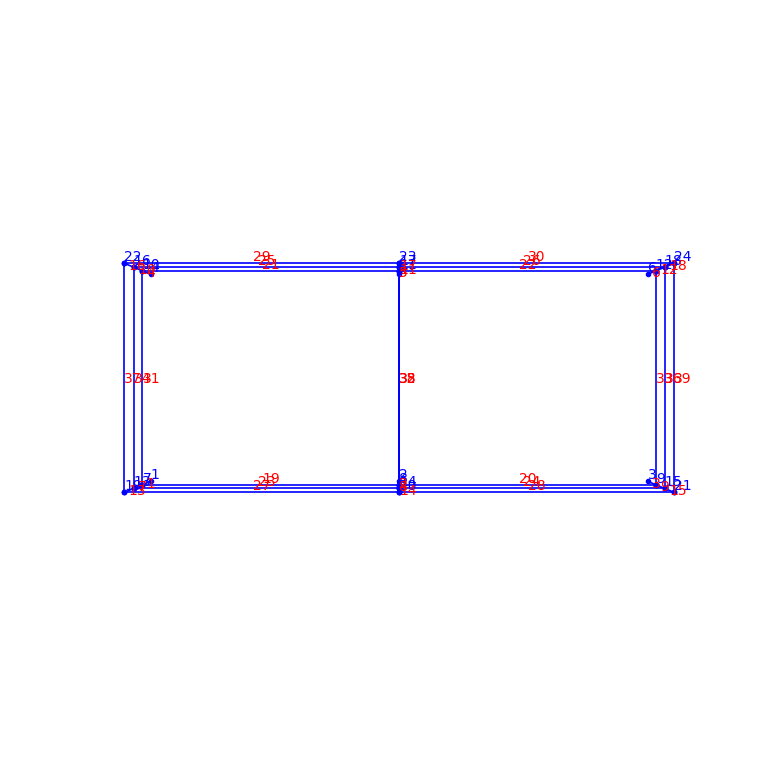

In [472]:
opsv.plot_model(fig_wi_he=(30.,25.),az_el=(90,-270),axis_off=1,local_axes=False, node_supports = False,nodes_only=False)
plt.show

In [473]:
def xyz2area(xyz):
    p0, p1, p2, p3 = xyz
    a1 = 0.5*np.linalg.norm(np.cross(p1 - p0, p2 - p0))
    a2 = 0.5*np.linalg.norm(np.cross(p2 - p0, p3 - p0))
    return a1 + a2


# ===== Piso a analizar (0 = base, 1 = primer piso, etc.)
indice_piso = 1

nodos_por_nivel = numero_ejes_x * numero_ejes_y
inicio = indice_piso * nodos_por_nivel
fin = inicio + nodos_por_nivel

nodos_piso = nodos[inicio:fin]  # nodos (x,y,z) Pisos similares


# ===== Paños de losa (cuadriláteros) en ese piso: (nx-1)*(ny-1)
losas = []
for iy in range(numero_ejes_y - 1):
    for ix in range(numero_ejes_x - 1):
        n1 = iy*numero_ejes_x + ix
        n2 = iy*numero_ejes_x + (ix + 1)
        n3 = (iy + 1)*numero_ejes_x + (ix + 1)
        n4 = (iy + 1)*numero_ejes_x + ix
        losas.append([n1, n2, n3, n4])


# ===== Áreas tributarias por nodo (en el piso)
areas = np.zeros(nodos_por_nivel, "f8")

for i in range(len(losas)):
    xyz = nodos_piso[losas[i]]
    area = xyz2area(xyz)
    area_trib = area/len(xyz)
    areas[losas[i]] += area_trib

areas


array([ 7.5, 15. ,  7.5,  7.5, 15. ,  7.5])

In [474]:
#Metrado de cargas
wLive = 250*kg/m**2
wLosa = 300*kg/m**2
wAcab = 100*kg/m**2
wTabi = 150*kg/m**2
wTotal = 1*(wLosa+wAcab+wTabi)+0.25*wLive  #kg/m2

m_nodos = areas*wTotal# Carga total por unidad de área

$xcm=\frac{\sum_{}^{}(x_o*m_o)}{\sum_{}^{}m_o}$

$ycm=\frac{\sum_{}^{}(y_o*m_o)}{\sum_{}^{}m_o}$

In [475]:
total_mass= np.sum(m_nodos)

x_cm = np.sum(nodos_piso[:,0]*m_nodos)/total_mass
y_cm = np.sum(nodos_piso[:,1]*m_nodos)/total_mass

In [476]:
# agregando nodos del CM
tags_cm = []
tags_existentes = ops.getNodeTags()
tag_libre = int(max(tags_existentes) + 1) if len(tags_existentes) > 0 else 1

for piso in range(1, numero_entrepiso + 1):
    z_cm = piso * altura_entrepiso
    ops.node(tag_libre, x_cm, y_cm, z_cm)
    ops.fix(tag_libre, *[0,0,1,1,1,0])
    tags_cm.append(tag_libre)
    tag_libre += 1

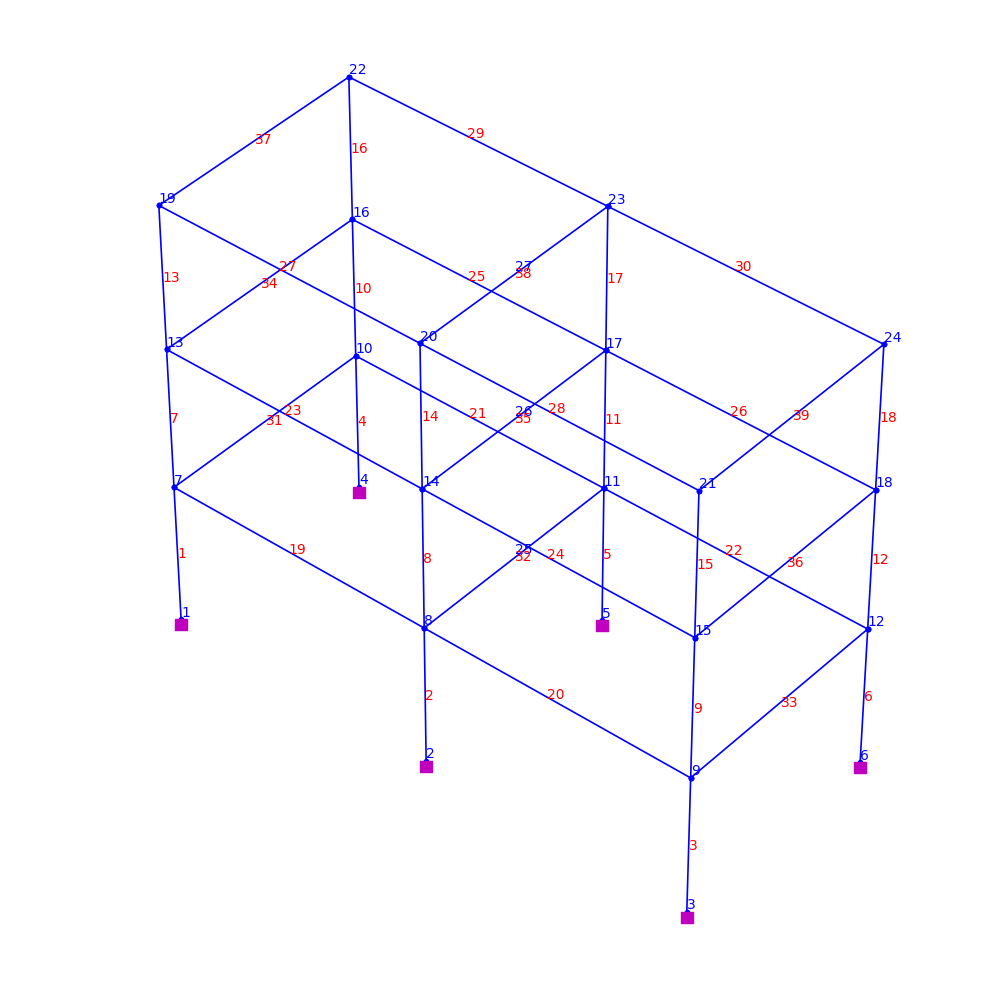

In [477]:
#Asociando nodos al diafragma rigido
perpDirn = 3  # Dirección perpendicular al diafragma (Z)

nodos_por_nivel = numero_ejes_x * numero_ejes_y

for piso in range(1, numero_entrepiso + 1):  # 1..numero_entrepiso (sin base)
    tag_cm = tags_cm[piso - 1]

    inicio = piso * nodos_por_nivel
    fin = inicio + nodos_por_nivel
    nodos_piso_tags = list(range(inicio + 1, fin + 1))

    ops.rigidDiaphragm(perpDirn, tag_cm, *nodos_piso_tags)
    
opsv.plot_model(fig_wi_he=(30.,25.),az_el=(-50,40),fig_lbrt = (0, 0, 1, 1),axis_off=1,local_axes=False)
plt.show()

In [478]:
# Asignación de masas nodales por piso

nodos_por_nivel = numero_ejes_x * numero_ejes_y  # debe coincidir con len(m_nodos)

for piso in range(1, numero_entrepiso + 1):
    for i in range(nodos_por_nivel):
        tag_nodo = piso * nodos_por_nivel + (i + 1)
        ops.mass(tag_nodo, *[m_nodos[i], m_nodos[i], 0.0])

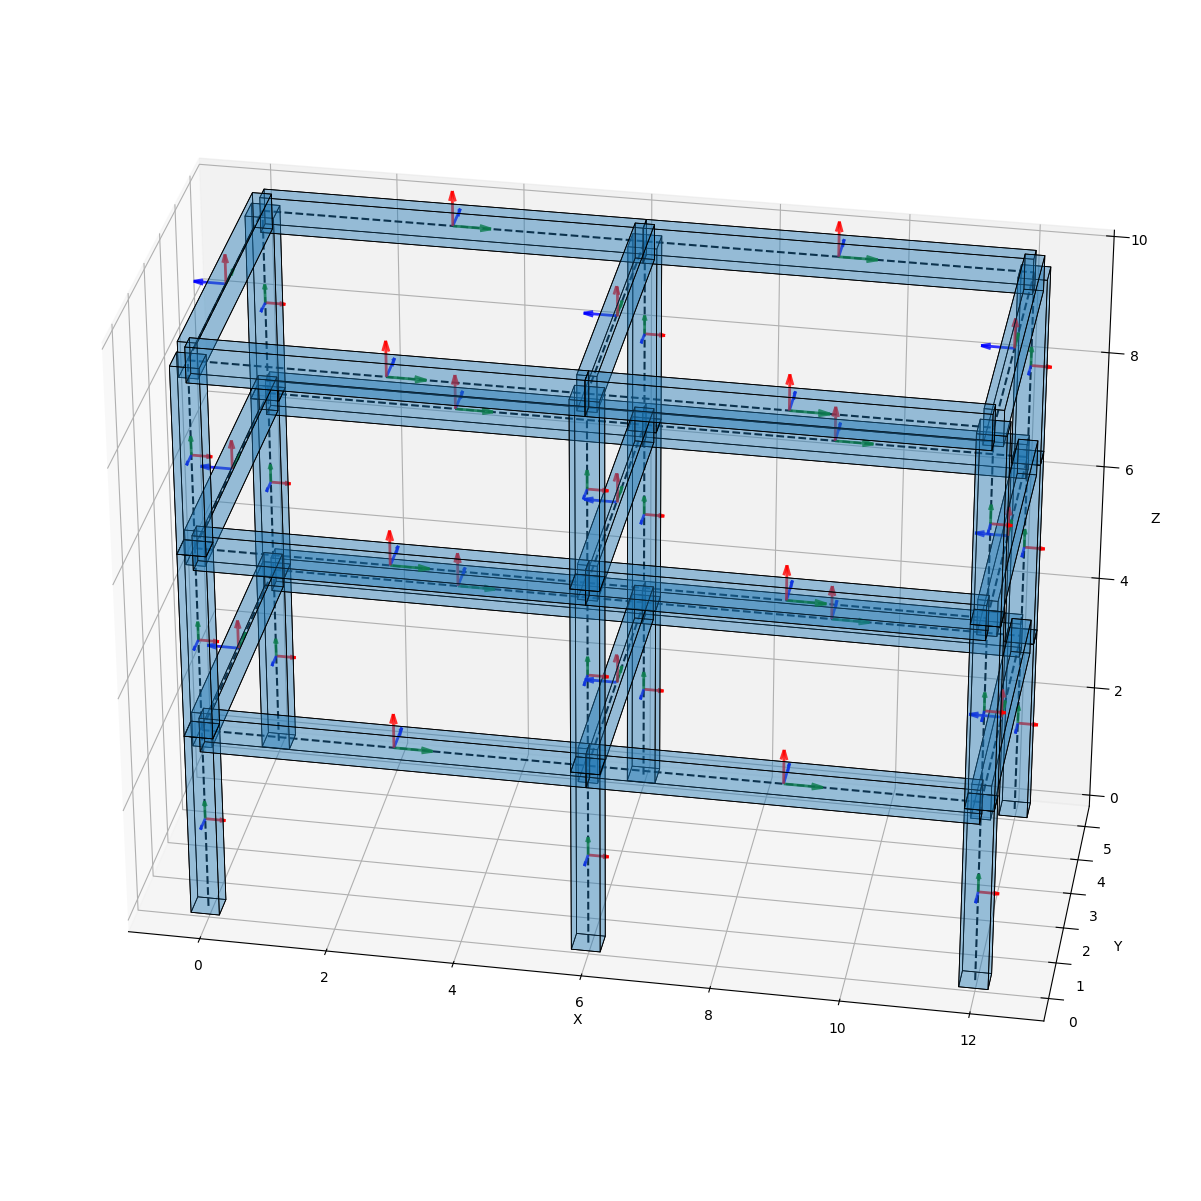

In [479]:
# Ploteo de forma extruída 3D de elementos
ele_shapes = {}

for tag_ele in tags_columnas:
    ele_shapes[tag_ele] = ['rect', [a, a]]     # columna

for tag_ele in tags_vigas:
    ele_shapes[tag_ele] = ['rect', [h, b]]     # viga

opsv.plot_extruded_shapes_3d(
    ele_shapes,
    fig_wi_he=(30., 30.),
    az_el=(-80, 30),
    fig_lbrt=(0, 0, 1, 1)
)
plt.show()

In [480]:
Nmodos = 3 * numero_entrepiso
vals = np.array(ops.eigen(Nmodos))
omega = vals**0.5
Tmodes = 2*np.pi/omega

for i in range(Nmodos):
    print("T[%i]: %.4f seg" % (i+1, Tmodes[i]))

T[1]: 0.4428 seg
T[2]: 0.4297 seg
T[3]: 0.3545 seg
T[4]: 0.1176 seg
T[5]: 0.1159 seg
T[6]: 0.0989 seg
T[7]: 0.0563 seg
T[8]: 0.0562 seg
T[9]: 0.0494 seg


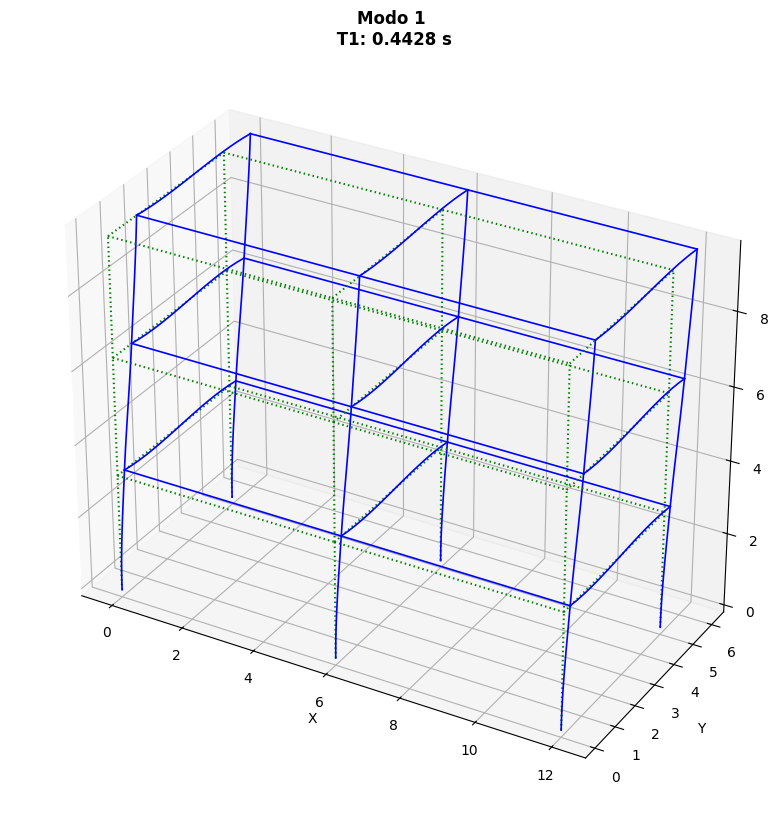

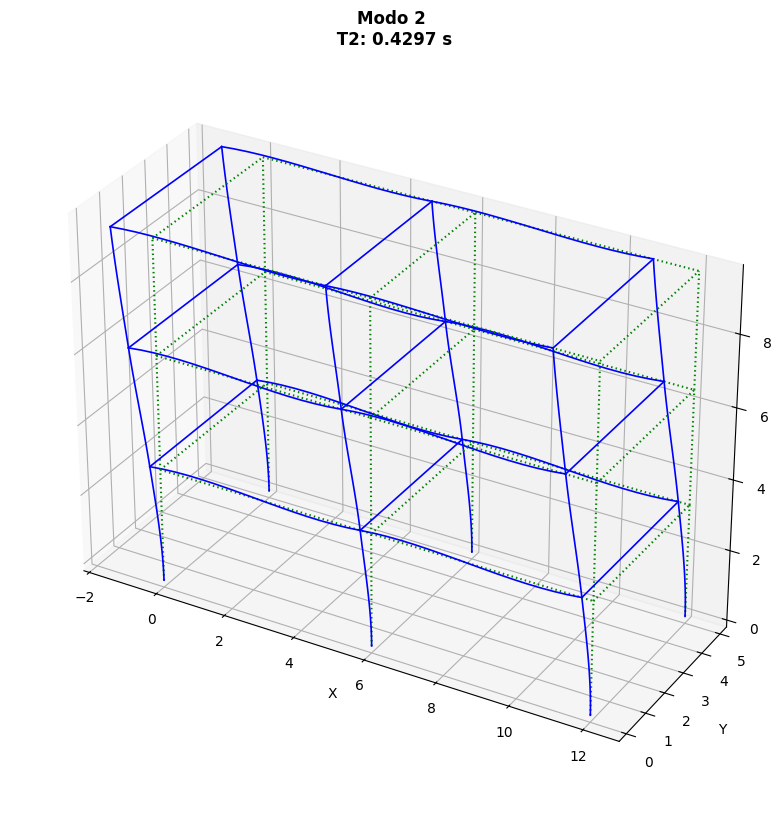

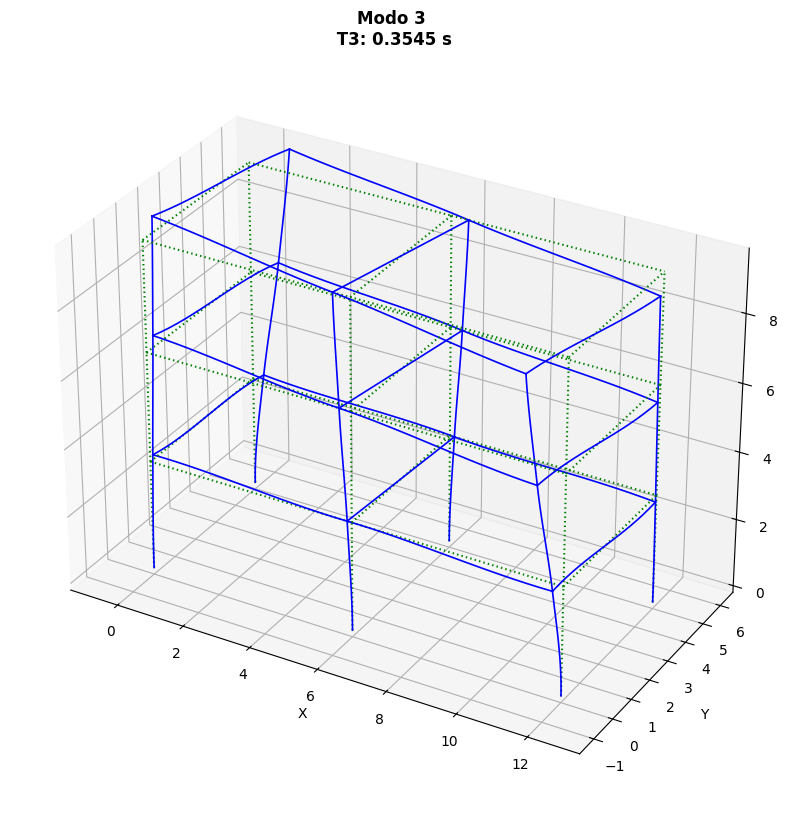

In [481]:
Nmode = 3
fmt_undefo = {'color': 'green', 'linestyle': (0, (0.7, 1.5)), 'linewidth': 1.5, 'marker': '', 'markersize': 1}
for i in range(Nmode):
    opsv.plot_mode_shape(i+1, endDispFlag=0, fig_wi_he=(25,30), fmt_undefo=fmt_undefo, node_supports=False)
    plt.title(f"Modo {i+1}\n T{i+1}: {Tmodes[i]:.4f} s", fontweight='bold')